# Approximating Pulses

In PVQ, codewords aren't taken from a codebook, they must follow a specific rule, their sum of absolute difference or L1-Norm must equal K.

As such, finding the codeword corresponding to a given vector is not trivial. 

In this notebook, we will look into approximating pulses to see how accurately we can estimate how the energy is distributed from the left and right sides of the codeword. More precisely, we are interested in the absolute sum of the left half $K_{\text{Left}}$ and the absolute sum of the right half $K_{\text{Right}}$.

## Basic Setup
First, we need to import a few things

In [6]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt

[![](images/python.png)](http://xkcd.com/353/)

## Loading data files

We extracted the vector coefficient right before PVQ and their corresponding Codewords in seqF10_coeffs4x4.csv and seqF10_pulses4x4.csv respectively. For now we only consider the first 15 AC coefficients.

We gathered data from the first 10 frames of the sequences of the [video-1-short](https://people.xiph.org/~tdaede/sets/video-1-short/) dataset

  * akiyo_cif
  * ducks_take_off
  * grandma
  * park
  * sign_irene
  * sintel_trailer_2k
  * soccer

In [8]:
def LoadData(coeffFile, pulseFile, kFile):
    _coeffs = np.genfromtxt(coeffFile, delimiter=',')
    _coeffs = _coeffs[:,0:15]
    _pulses = np.genfromtxt(pulseFile, delimiter=',')
    _pulses = _pulses[:,0:15]
    _ks = np.genfromtxt(kFile, delimiter=',')
    
    _numLines = len(_ks)
    # Sanity check that the pulses match with k
    for i in range(0, _numLines):
        assert(_ks[i] == sum(abs(_pulses[i,:])))
        return _coeffs, _pulses, _ks

[akiyoCoeffs, akiyoPulses, akiyoKs] = LoadData("data/akiyoF10_coeffs4x4.csv", "data/akiyoF10_pulses4x4.csv",
                                               "data/akiyoF10_k4x4.csv");

[ducksCoeffs, ducksPulses, ducksKs] = LoadData("data/ducksF10_coeffs4x4.csv", "data/ducksF10_pulses4x4.csv",
                                               "data/ducksF10_k4x4.csv");

[grandmaCoeffs, grandmaPulses, grandmaKs] = LoadData("data/grandmaF10_coeffs4x4.csv", "data/grandmaF10_pulses4x4.csv",
                                               "data/grandmaF10_k4x4.csv");

[parkCoeffs, parkPulses, parkKs] = LoadData("data/parkF10_coeffs4x4.csv", "data/parkF10_pulses4x4.csv",
                                            "data/parkF10_k4x4.csv");

[signCoeffs, signPulses, signKs] = LoadData("data/signF10_coeffs4x4.csv", "data/signF10_pulses4x4.csv",
                                            "data/signF10_k4x4.csv");

[sintelCoeffs, sintelPulses, sintelKs] = LoadData("data/sintelF10_coeffs4x4.csv", "data/sintelF10_pulses4x4.csv",
                                                  "data/sintelF10_k4x4.csv");

[soccerCoeffs, soccerPulses, soccerKs] = LoadData("data/soccerF10_coeffs4x4.csv", "data/soccerF10_pulses4x4.csv",
                                            "data/soccerF10_k4x4.csv");

## Approximating Pulses
In PVQ, vectors are normalized, the resulting energy is referred to as the shape of the vector. By taking ratios of the energy, we can get a good approximation of where to spread the K values. We refer to these values as pulses.

In [120]:
def gain(v):
    return np.sqrt(np.dot(v,v))

def shape(v):
    return np.true_divide(v, gain(v))

def approximatePulses(_coeffs, _ks):
    _approxPulses = np.zeros(shape=_coeffs.shape)
    _roundedPulses = np.zeros(shape=_coeffs.shape)
    for i in range(0,len(_ks)):
        s = shape(_coeffs[i,:])
        _approxPulses[i] = np.true_divide(s,sum(np.abs(s)))*_ks[i]
    
    # Sanity check that the approximated pulses match with k     
    _numLines = len(_ks)
    for i in range(0, _numLines):
        assert(_ks[i] - sum(abs(_approxPulses[i,:])) < 0.0001)
        
    return _approxPulses

akiyoApproxPulses = approximatePulses(akiyoCoeffs, akiyoKs)
ducksApproxPulses = approximatePulses(ducksCoeffs, ducksKs)
grandmaApproxPulses = approximatePulses(grandmaCoeffs, grandmaKs)
parkApproxPulses = approximatePulses(parkCoeffs, parkKs)
signApproxPulses = approximatePulses(signCoeffs, signKs)
sintelApproxPulses = approximatePulses(sintelCoeffs, sintelKs)
soccerApproxPulses = approximatePulses(soccerCoeffs, soccerKs)

Note that with this approach we have fractional pulses. The absolute sum of these fractional pulses is K. However, if we round, floor or ceil the pulses, the absolute sum may no longer be K.

Based on this original estimate, the encoder will try to play with the pulses to obtain integer pulses and to improve the rate distortion ratio of the codeword.

Let's measure the mean absolute error between our approximated pulses and the pulses of the Daala encoder.

In [121]:
akiyoError = np.abs(akiyoPulses - np.round(akiyoApproxPulses)).sum(axis=1)
ducksError = np.abs(ducksPulses - np.round(ducksApproxPulses)).sum(axis=1)
grandmaError = np.abs(grandmaPulses - np.round(grandmaApproxPulses)).sum(axis=1)
parkError = np.abs(parkPulses - np.round(parkApproxPulses)).sum(axis=1)
signError = np.abs(signPulses - np.round(signApproxPulses)).sum(axis=1)
sintelError = np.abs(sintelPulses - np.round(sintelApproxPulses)).sum(axis=1)
soccerError = np.abs(soccerPulses - np.round(soccerApproxPulses)).sum(axis=1)


print("Average Absolute Approximation Error (in pulses)")
print("Akiyo: %0.2f" % np.mean(akiyoError))
print("Ducks: %0.2f" % np.mean(ducksError))
print("Grandma: %0.2f" % np.mean(grandmaError))
print("Park: %0.2f" % np.mean(parkError))
print("Sign: %0.2f" % np.mean(signError))
print("Sintel: %0.2f" % np.mean(sintelError))
print("Soccer: %0.2f" % np.mean(soccerError))


Average Absolute Approximation Error (in pulses)
Akiyo: 1.27
Ducks: 1.64
Grandma: 1.31
Park: 1.52
Sign: 1.32
Sintel: 1.41
Soccer: 1.25


On average, our estimate is off by one or two pulses. 

## Error distribution

Now, let's look at how the error distributes over the codewords.

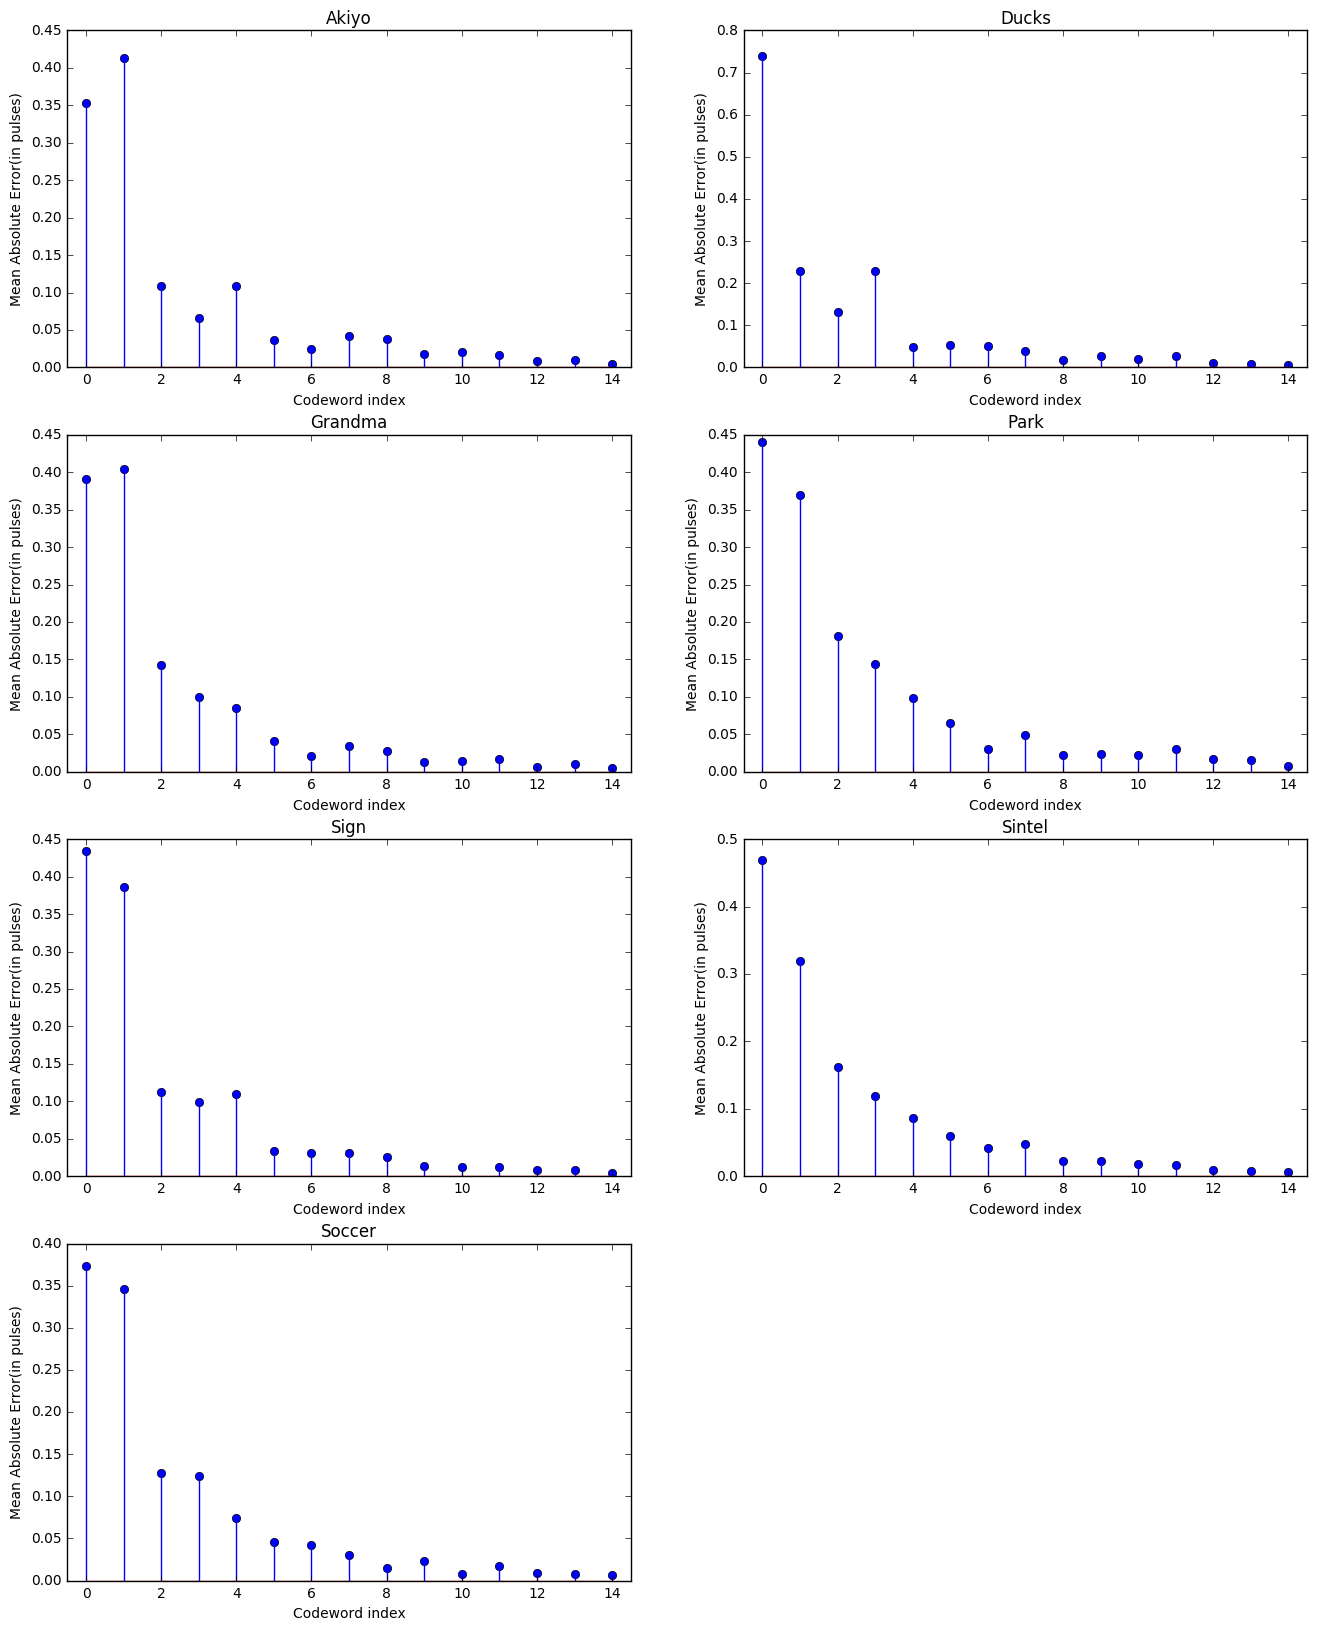

In [122]:
plt.figure(figsize=(16,20));
plt.subplot(4,2,1);
p = plt.stem(np.abs(akiyoPulses - np.round(akiyoApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Akiyo");
plt.gca().set_xlim([-0.5, 14.5])

plt.subplot(4,2,2);
plt.stem(np.abs(ducksPulses - np.round(ducksApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Ducks");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,3);
plt.stem(np.abs(grandmaPulses - np.round(grandmaApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Grandma");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,4);
plt.stem(np.abs(parkPulses - np.round(parkApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)")
plt.xlabel("Codeword index");
plt.title("Park");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,5)
plt.stem(np.abs(signPulses - np.round(signApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Sign");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,6);
plt.stem(np.abs(sintelPulses - np.round(sintelApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Sintel");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,7);
plt.stem(np.abs(soccerPulses - np.round(soccerApproxPulses)).mean(axis=0));
plt.ylabel("Mean Absolute Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Soccer");
plt.gca().set_xlim([-0.5, 14.5]);

It would appear the daala's PVQ encoder is left biased, as most of the error is in the left part.

## Negative vs Positive bias

Next, let's do the same test but this time without the absolute operator. This way, we can see if there's a positive or negative bias for the codeword indices.

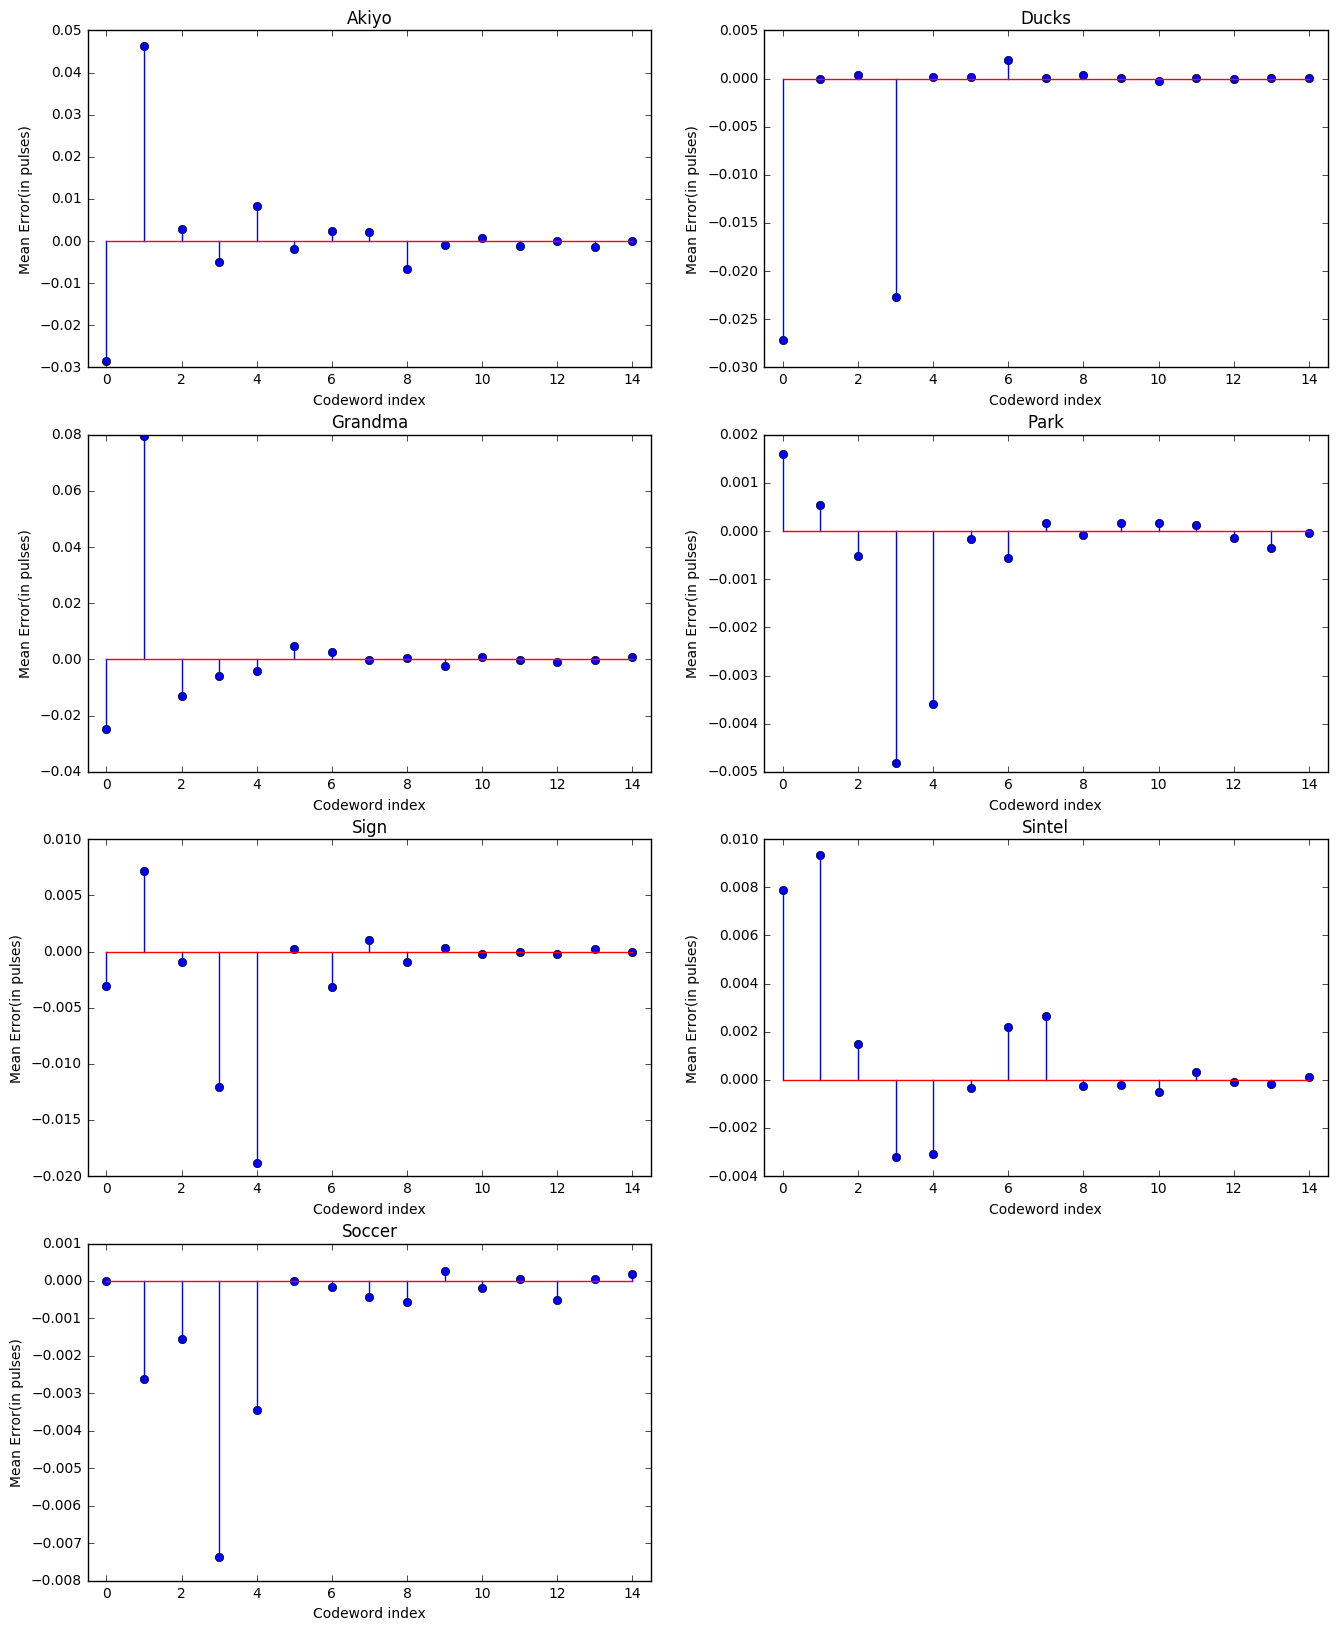

In [84]:
plt.figure(figsize=(16,20));
plt.subplot(4,2,1);
p = plt.stem((akiyoPulses - np.round(akiyoApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Akiyo");
plt.gca().set_xlim([-0.5, 14.5])

plt.subplot(4,2,2);
plt.stem((ducksPulses - np.round(ducksApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Ducks");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,3);
plt.stem((grandmaPulses - np.round(grandmaApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Grandma");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,4);
plt.stem((parkPulses - np.round(parkApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)")
plt.xlabel("Codeword index");
plt.title("Park");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,5)
plt.stem((signPulses - np.round(signApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Sign");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,6);
plt.stem((sintelPulses - np.round(sintelApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Sintel");
plt.gca().set_xlim([-0.5, 14.5]);

plt.subplot(4,2,7);
plt.stem((soccerPulses - np.round(soccerApproxPulses)).mean(axis=0));
plt.ylabel("Mean Error(in pulses)");
plt.xlabel("Codeword index");
plt.title("Soccer");
plt.gca().set_xlim([-0.5, 14.5]);

Although the left bias is present in every sequence of the dataset, the negative vs positive bias appears to be content specific.

## Estimating KLeft

Now on to the main event, predicting the value of K for the left half.

In [249]:
akiyoLeftError = np.abs(akiyoPulses[:,0:7]).sum(axis=1) - np.abs(np.round(akiyoApproxPulses[:,0:7])).sum(axis=1)
ducksLeftError = np.abs(ducksPulses[:,0:7]).sum(axis=1) - np.abs(np.round(ducksApproxPulses[:,0:7])).sum(axis=1)
grandmaLeftError = np.abs(grandmaPulses[:,0:7]).sum(axis=1) - np.abs(np.round(grandmaApproxPulses[:,0:7])).sum(axis=1)
parkLeftError = np.abs(parkPulses[:,0:7]).sum(axis=1) - np.abs(np.round(parkApproxPulses[:,0:7])).sum(axis=1)
signLeftError = np.abs(signPulses[:,0:7]).sum(axis=1) - np.abs(np.round(signApproxPulses[:,0:7])).sum(axis=1)
sintelLeftError = np.abs(sintelPulses[:,0:7]).sum(axis=1) - np.abs(np.round(sintelApproxPulses[:,0:7])).sum(axis=1)
soccerLeftError = np.abs(soccerPulses[:,0:7]).sum(axis=1) - np.abs(np.round(soccerApproxPulses[:,0:7])).sum(axis=1)

print("Average Absolute Approximation Error Left (in pulses)")
print("Akiyo: %0.2f" % np.mean(np.abs(akiyoLeftError)))
print("Ducks: %0.2f" % np.mean(np.abs(ducksLeftError)))
print("Grandma: %0.2f" % np.mean(np.abs(grandmaLeftError)))
print("Park: %0.2f" % np.mean(np.abs(parkLeftError)))
print("Sign: %0.2f" % np.mean(np.abs(signLeftError)))
print("Sintel: %0.2f" % np.mean(np.abs(sintelLeftError)))
print("Soccer: %0.2f" % np.mean(np.abs(soccerLeftError)))


Average Absolute Approximation Error Left (in pulses)
Akiyo: 1.06
Ducks: 1.38
Grandma: 1.14
Park: 1.28
Sign: 1.16
Sintel: 1.23
Soccer: 1.04


## The Glass is not half empty

Turns out that predicting the left half is tricky, because the codewords vary from our estimates based on elements specific to the content. However, the right half is much more stable, and since we know K, we can use the complement to estimate $K_{\text{left}}$

In [212]:
akiyoLeftErrorC = np.abs(akiyoPulses[:,0:7]).sum(axis=1) - (akiyoKs - np.abs(np.round(akiyoApproxPulses[:,7:15])).sum(axis=1))
ducksLeftErrorC = np.abs(ducksPulses[:,0:7]).sum(axis=1) - (ducksKs - np.abs(np.round(ducksApproxPulses[:,7:15])).sum(axis=1))
grandmaLeftErrorC = np.abs(grandmaPulses[:,0:7]).sum(axis=1) - (grandmaKs - np.abs(np.round(grandmaApproxPulses[:,7:15])).sum(axis=1))
parkLeftErrorC = np.abs(parkPulses[:,0:7]).sum(axis=1) - (parkKs - np.abs(np.round(parkApproxPulses[:,7:15])).sum(axis=1))
signLeftErrorC = np.abs(signPulses[:,0:7]).sum(axis=1) - (signKs - np.abs(np.round(signApproxPulses[:,7:15])).sum(axis=1))
sintelLeftErrorC = np.abs(sintelPulses[:,0:7]).sum(axis=1) - (sintelKs - np.abs(np.round(sintelApproxPulses[:,7:15])).sum(axis=1))
soccerLeftErrorC = np.abs(soccerPulses[:,0:7]).sum(axis=1) - (soccerKs - np.abs(np.round(soccerApproxPulses[:,7:15])).sum(axis=1))

print("Average Absolute Approximation Error Left (in pulses)")
print("Akiyo: %0.2f" % np.mean(np.abs(akiyoLeftErrorC)))
print("Ducks: %0.2f" % np.mean(np.abs(ducksLeftErrorC)))
print("Grandma: %0.2f" % np.mean(np.abs(grandmaLeftErrorC)))
print("Park: %0.2f" % np.mean(np.abs(parkLeftErrorC)))
print("Sign: %0.2f" % np.mean(np.abs(signLeftErrorC)))
print("Sintel: %0.2f" % np.mean(np.abs(sintelLeftErrorC)))
print("Soccer: %0.2f" % np.mean(np.abs(soccerLeftErrorC)))


Average Absolute Approximation Error Left (in pulses)
Akiyo: 0.15
Ducks: 0.16
Grandma: 0.12
Park: 0.18
Sign: 0.11
Sintel: 0.15
Soccer: 0.11


## KLeft estimate vs KLeft Complement estimate

Our complement based estimates are much more accurate, this is confirmed by looking at the histogram of the error:

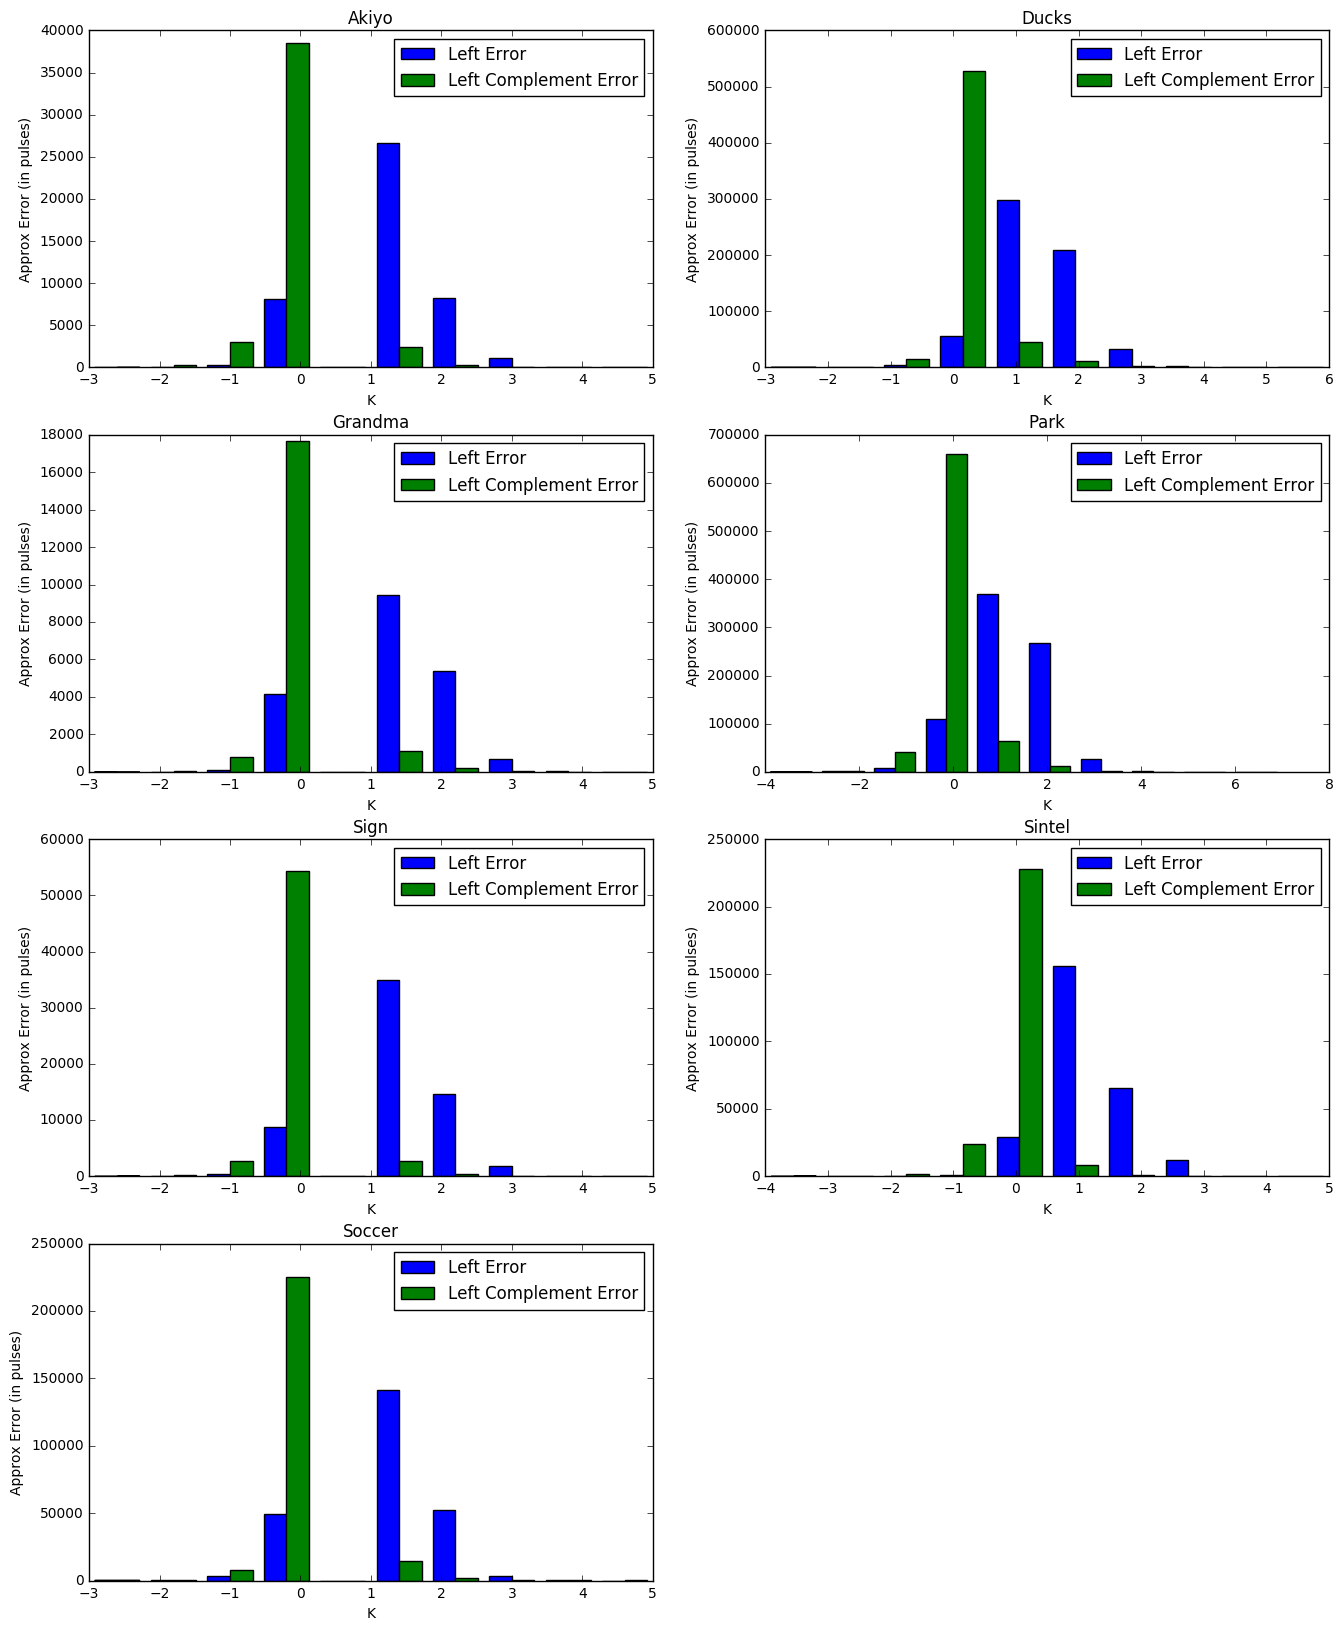

In [257]:
plt.figure(figsize=(16,20));
plt.subplot(4,2,1);
plt.hist([akiyoLeftError, akiyoLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Akiyo")
plt.legend(["Left Error","Left Complement Error"])

plt.subplot(4,2,2);
plt.hist([ducksLeftError, ducksLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Ducks")
plt.legend(["Left Error","Left Complement Error"])

plt.subplot(4,2,3);
plt.hist([grandmaLeftError, grandmaLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Grandma")
plt.legend(["Left Error","Left Complement Error"])

plt.subplot(4,2,4);
plt.hist([parkLeftError, parkLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Park")
plt.legend(["Left Error","Left Complement Error"])

plt.subplot(4,2,5);
plt.hist([signLeftError, signLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Sign")
plt.legend(["Left Error","Left Complement Error"])

plt.subplot(4,2,6);
plt.hist([sintelLeftError, sintelLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Sintel")
plt.legend(["Left Error","Left Complement Error"])

plt.subplot(4,2,7);
plt.hist([soccerLeftError, soccerLeftErrorC]);
plt.ylabel("Approx Error (in pulses)");
plt.xlabel("K");
plt.title("Soccer")
plt.legend(["Left Error","Left Complement Error"]);

## Conclusion

In this notebook, we looked at the accuracy of estimating the energy of the pulses based on the energy of the coefficients. From our dataset, we concluded, that the left half of the coefficient seem to be the hardest to estimate and that by estimating the right half and using the complement we obtained better results.